In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
#from cipher import *
#from scheme import *

from time import time
from PIL import Image

import torch
import torchvision.transforms as transforms

import cv2

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


In [66]:
from heconv import sumslots, VEC, multiplex, selecting_tensor, get_Up
from heconv_tests import test_sumslots, test_VEC, test_multiplex
from math import floor, ceil, sqrt


def unpack(ct, ha, wa, ka, ta): 
    #fh,fw= self.get_kernels()
    ch=[]
    for k in range(ka**2):
        mat=[]
        for i in range(ha):
            iflat = i*wa*ka**2
            row = []
            for j in range(wa):
                jflat = j*ka + k%ka + floor(k/ka)*ka*wa
                row.append(ct[iflat+jflat])
            mat.append(row)
        ch.append(mat) 
    return np.array(ch)

In [4]:
#from hlee_utils import get_channel_first, get_channel_last

fimage="./hy/cute.jpg"
image = cv2.imread(fimage)
image = cv2.resize(image,(32,32))
#img = get_channel_first(image)
#img = torch.tensor(img)
#img = img.type(torch.DoubleTensor)

#torout = tor.TorchConv(fimage)

In [117]:
#from hy.hlee_cnn import TorchConv_infer
from argparse import Action
from ast import AsyncFunctionDef
from hy.hlee_model import ConvNeuralNet_simple
from torch.nn import functional as F

co=16
fp=f"./hy/models/simple_model_hlee_co{co}.pt"

tor = ConvNeuralNet_simple(num_classes=10, activation=F.relu, co=co)
tor.load_state_dict(torch.load(fp))

channel out : 16
channel out : 16


<All keys matched successfully>

In [118]:
nslots = 16384

packed = VEC(multiplex(image),nslots)

In [119]:
from audioop import add


Uin = tor.conv_layer1.weight.detach().numpy()
Uin = Uin.transpose(2,3,1,0)
print(Uin.shape)

fh, fw, ci, co = Uin.shape
hi, wi, ci = image.shape
print(image.shape)

ki = ceil(sqrt(ci))
ko = ceil(sqrt(co))
ti = ceil(ci/ki**2)

### no striding
ho = hi
wo = wi
###
to = ceil(co/ko**2)

ctd = np.zeros(nslots)

cts=[]
for i1 in range(fh):
    cti1=[]
    for i2 in range(fw):
        lrots = int((-(ki**2)*wi*(i1-(fh-1)/2) - ki*(i2-(fw-1)/2)))
        cti1.append(np.roll(packed,lrots))
        #cti1.append(np.roll(packed, -ki**2*wi*int(i1-(fh-1)/2) + ki*int(i2-(fw-1)/2))) # -?
        print(f"[MultConv][(fh,fw) LOOP] rot [{lrots:5}] #rotation_count = {lrots}")
    cts.append(cti1)

#len_multwgt = ki*
Uout = np.zeros((ki*hi,ki*wi,ti))

allarr = []

for i in range(co):
    ctb = np.zeros(nslots)
    for i1 in range(fh):
        for i2 in range(fw):
            Uout[:] = 0
            get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci)
            multwgt = VEC(Uout, nslots)
            len_multwgt = len(multwgt)
            ctb[:len_multwgt] += cts[i1][i2][:len_multwgt] * multwgt            
    #print(ctb)
    ctc = sumslots(ctb, ki, 1) # input의 한 axis 확장 크기만큼 sum
    ctc_ = sumslots(ctc, ki, ki*wi) # 
    
    #ctc = sumslots(ctc_, ti, ki**2*hi*wi) # multiplexed input한 장 넘기기 
    #print(np.all(ctc == ctc_))

    S = selecting_tensor(ko, ho, wo, to, i)

    r1 =  int(np.floor(i/(ko**2))*ko**2*(ho)*(wo)) 
    r2 =  int(np.floor((i%(ko**2))/ko)*ko*(wo))
    r3 =  (i%ko)
    rrots = -(r1+r2+r3)

    rolled = np.roll(ctc, rrots)
    #print(i, "RR Non-zero values", np.sum(rolled !=0))
    vectorized = VEC(S, nslots)
    #vectorized = np.zeros(nslots)
    #vectorized[rolled !=0] = 1
    #print(i, "SS Non-zero values", np.sum(vectorized !=0)) #1024가 맞는 듯 
    addition = rolled * vectorized
    #print(i, "Non-zero values", np.sum(addition !=0))
    ctd += addition
    ctd += np.roll(ctc, (floor(i/ko**2)*ko**2*ho*wo + floor((i % ko**2)/ko)*ko*wo + (i % ko))) * VEC(S, nslots)
    #allarr.append(addition)
    lskip = ko*wo
    print(i, ctd[lskip:lskip+16])

(3, 3, 3, 16)
(32, 32, 3)
[MultConv][(fh,fw) LOOP] rot [  130] #rotation_count = 130
[MultConv][(fh,fw) LOOP] rot [  128] #rotation_count = 128
[MultConv][(fh,fw) LOOP] rot [  126] #rotation_count = 126
[MultConv][(fh,fw) LOOP] rot [    2] #rotation_count = 2
[MultConv][(fh,fw) LOOP] rot [    0] #rotation_count = 0
[MultConv][(fh,fw) LOOP] rot [   -2] #rotation_count = -2
[MultConv][(fh,fw) LOOP] rot [ -126] #rotation_count = -126
[MultConv][(fh,fw) LOOP] rot [ -128] #rotation_count = -128
[MultConv][(fh,fw) LOOP] rot [ -130] #rotation_count = -130
0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [ 6.99189206  0.          0.          0.         44.55015072  0.
  0.          0.         42.90152521  0.          0.          0.
 51.51366613  0.          0.          0.        ]
5 [ 6.99189206  7.89479303  0.          0.         44.5

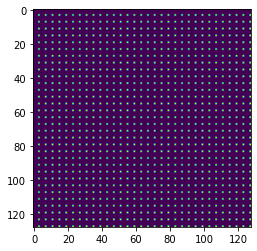

In [120]:
plt.imshow(S[:,:,0])

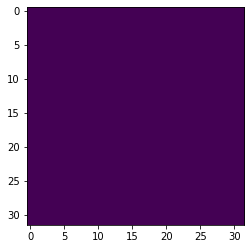

In [82]:
plt.imshow(unpack(vectorized, hi, wi, ki, ti)[0,:,:])

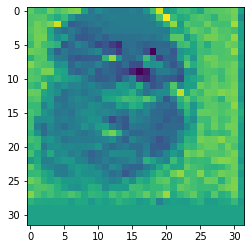

In [70]:
plt.imshow(unpack(rolled, hi, wi, ki,ti)[0,:,:])

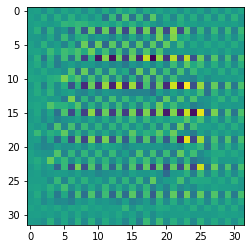

In [93]:
plt.imshow(unpack(ctd[0:], hi, wi, ki,ti)[0,:,:])

In [125]:
unpacked = unpack(ctd, hi, wi, ki, ti)#[0,:,:]

#plt.imshow()

In [126]:
unpacked.shape

(4, 32, 32)

In [34]:
print(i, "Non-zero values", np.sum(addition !=0))


15 Non-zero values 256


In [41]:
np.sum(ctd != 0)

4483

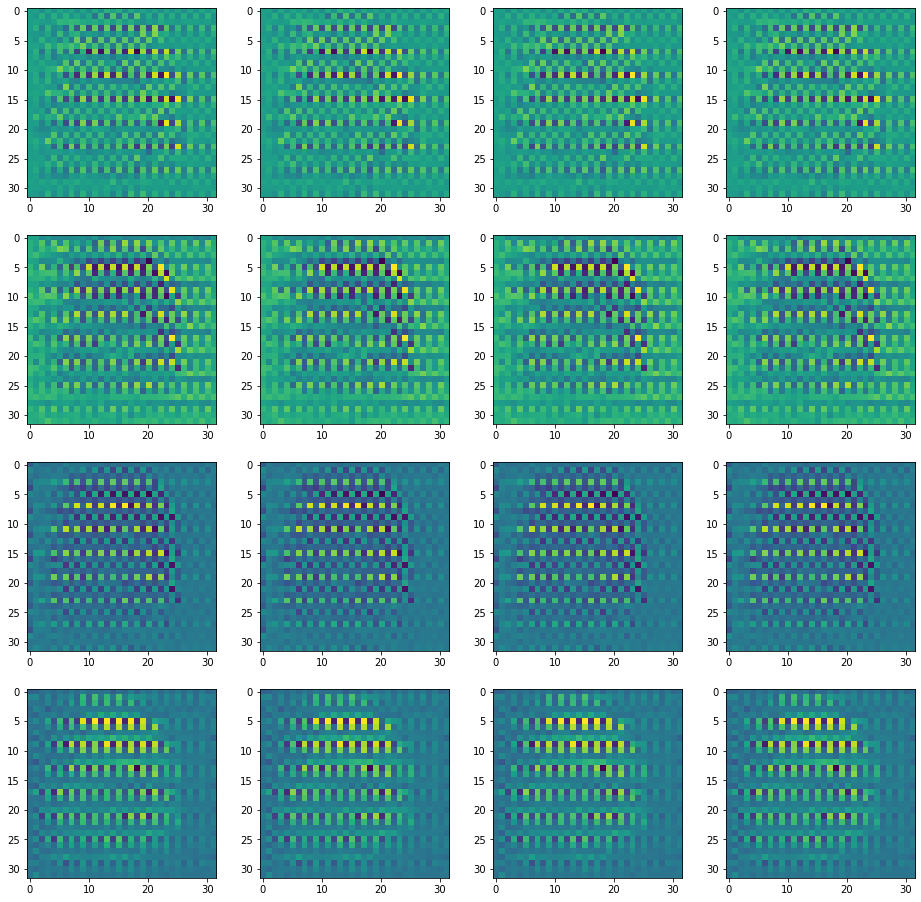

In [129]:
reconstructed = unpack(ctd, ho, wo, ki, to)
fig, axs = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(reconstructed[i,:,:])
plt.show()

In [107]:
plt.close("all")